In [363]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# N-in-N-out architecture

In [132]:
import tensorflow as tf
import cv2
import math
import numpy as np

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *
from tensorflow.keras.losses import *

from focal_loss import binary_focal_loss

In [333]:
drop = 0.1
def conv_block(x, filters, size=3):
    x = Conv1D(
        filters, size,
        kernel_initializer='he_uniform', padding='same', 
        data_format='channels_last')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(drop)(x)
    x = PReLU()(x)
    return x

def down_block(x, filters, repeats):
    for i in range(repeats):
        x = conv_block(x, filters, 3)
    y = MaxPooling1D(
        2, strides=2, 
        data_format='channels_last')(x)
    return y, x
    
def up_block(x, xu, filters, repeats, use_res=False, channel_first=True):
    x = concatenate([
            Conv1DTranspose(
                filters, 
                kernel_size=2, strides=2, 
                data_format='channels_last')(x), 
            xu], axis=-1)
    for i in range(repeats):
        x = conv_block(x, filters)
    return x

input_layer = Input(shape=(x_train.shape[1],))
# x = Reshape(
#     target_shape=(num_consec, x_train.shape[1] // (num_consec))
# )(input_layer)

# # Down block
# x, x1 = down_block(x, 16, 2)
# x, x2 = down_block(x, 32, 2)

# Bottom block
# for i in range(5):
#     x = conv_block(x, 64)

# # # Up block
# x = up_block(x, x2, 32, 2)
# x = up_block(x, x1, 16, 2)

# Final output
x = Flatten()(Dense(1)(x))
x = Dense(512, activation='relu')(input_layer)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(num_consec)(x)
output_layer = Activation('sigmoid')(x)#tf.clip_by_value(x, 0., 1.)

model = Model(input_layer, output_layer)

In [334]:
def dice_loss(y_true, y_pred, smooth=K.epsilon()):
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    intersection = K.sum(y_true * y_pred, axis=-1) + smooth
    union = K.sum(y_true + y_pred, axis=-1) + 2. * smooth
    return 1 - 2. * intersection / union

def combo_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + binary_crossentropy(y_true, y_pred)

def custom_loss(y_true, y_pred):
    return binary_focal_loss(y_true, y_pred, 2.)

In [338]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)
model.summary()

Model: "functional_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 78)]              0         
_________________________________________________________________
dense_107 (Dense)            (None, 512)               40448     
_________________________________________________________________
dense_108 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_109 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_110 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_111 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_112 (Dense)            (None, 512)             

In [339]:
# NTS: You've augmented x_train with the literal answer and the network isnt learning! Something is wrong!!!

In [ ]:
# from tensorflow.keras import backend as K
# K.set_value(model.optimizer.learning_rate, 1e-4)

model.fit(
    x_train, y_train, 
    batch_size=128, 
    epochs=900,
#     class_weight={0: 1, 1: 2, 2: 2},
    shuffle=True,
#     validation_data=(x_val, y_val),
    verbose=1
)

# Data loading

In [364]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

In [365]:
def scale_data(x):
    x = np.array(x)
    def scale_by_col(x, cols):
        x_ = x[:, cols]
        m, M = np.min(x_[x_ != 0]), np.max(x_[x_ != 0])
        x_[x_ != 0] = (x_[x_ != 0] - m) / (M - m) + 1
        x[:, cols] = x_
        return x

    even_cols = [2*i for i in range(x.shape[1] // 2)]
    odd_cols = [2*i+1 for i in range(x.shape[1] // 2)]
    x = scale_by_col(x, even_cols)
    x = scale_by_col(x, odd_cols)
    return x

def reflect(x):
    x_ = np.array(x)
    for i in range(0, x.shape[1], 2):
        x_[:, i] = width - x_[:, i]
    return x_

In [366]:
import os
import pandas as pd
import numpy as np
import cv2
from scipy.stats import mode
from scipy.ndimage.interpolation import shift

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

num_consec = 32
subwindow_size = 32
matches = list('match' + str(i) for i in range(1,2))#, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale

x_train, y_train = [], []
for match in matches:
    basedir = '/home/code-base/scratch_space/data/%s' % match
    for video in os.listdir('%s/rally_video/' % basedir):
        if '.mp4' not in video:
            continue
        for speed in [1.]:#[0.833, 1.0, 1.2]:
            rally, _ = os.path.splitext(video)
            trajectory = Trajectory(
                '%s/ball_trajectory/%s_ball.csv' % (basedir, rally),
                interp=False
            )
            hit = pd.read_csv('%s/shot/%s_hit.csv' % (basedir, rally))

            poses = read_player_poses('%s/poses/%s' % (basedir, rally))
            bottom_player, top_player = poses[0], poses[1]

            x_list, y_list = [], []
            court_pts = read_court('%s/court/%s.out' % (basedir, rally))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            
            cap = cv2.VideoCapture('%s/rally_video/%s' % (basedir, video))
            _, frame = cap.read()
            height, width = frame.shape[:2]

            from skimage.transform import rescale, resize
            def resample(series, s):
                flatten = False
                if len(series.shape) == 1:
                    series.resize((series.shape[0], 1))
                    series = series.astype('float64')
                    flatten = True
                series = resize(
                    series, (int(s * series.shape[0]), series.shape[1]),
                )
                if flatten:
                    series = series.flatten()
                return series            
            
            y_tmp = np.array(hit.values[:,1])
            y_new = np.zeros(y_tmp.shape)
            for i in range(-2, 2):
                y = shift(y_tmp, i, cval=0.)
                y_new += y
                
            trajectory.X = resample(np.array(trajectory.X), speed)
            trajectory.Y = resample(np.array(trajectory.Y), speed)
            bottom_player = resample(bottom_player.values, speed)
            top_player = resample(top_player.values, speed)
            y_tmp = resample(y_tmp, speed).round()
            
            
            for i in range(num_consec):
                end = min(len(trajectory.X), len(hit))-num_consec+i+1
                x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

                # Use entire pose
                x_pose = np.hstack([bottom_player[i:end], top_player[i:end]])
                x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

                y = y_new[i:end]
                x_list.append(x)
                y_list.append(y)

            x_t = np.hstack(x_list)
            y_t = np.column_stack(y_list[-subwindow_size:]).astype('float')
            
            identity = lambda x: x
            augmentations = [identity]
            for transform in augmentations:
                x_train.append(scale_data(transform(x_t)))
                y_train.append(y_t)

                x_train.append(scale_data(transform(reflect(x_t))))
                y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.vstack(y_train)

print(x_train.shape, y_train.shape)

(5852, 2496) (5852, 32)


In [367]:
# Get validation data
x_val, y_val = [], []
parent_dir = "/home/code-base/user_space/ai-badminton/notebooks/data/test_data"
base_dir = "/home/code-base/user_space/ai-badminton/notebooks/data/test_data/test_all"
for dirname in os.listdir(base_dir):
    if 'match' not in dirname:
        continue
    try:
        match, rally = dirname.split('-')
        match = 'test_' + match
        video = '%s/%s/rally_video/%s.mp4' % (base_dir, dirname, rally)

        trajectory = Trajectory(
            '%s/%s/ball_trajectory/%s_ball.csv' % (base_dir, dirname, rally),
            interp=False
        )
        hit = pd.read_csv('%s/%s/shot/%s_hit.csv' % (parent_dir, match, rally))

        poses = read_player_poses('%s/%s/poses/%s' % (base_dir, dirname, rally))
        bottom_player, top_player = poses[0], poses[1]

        x_list, y_list = [], []
        court_pts = read_court('%s/%s/court/%s.out' % (base_dir, dirname, rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
        
        cap = cv2.VideoCapture(video)
        _, frame = cap.read()
        height, width = frame.shape[:2]
    except:
        print('Failed data fetch for match', dirname)
        continue
        
    y_tmp = np.array(hit.hit.to_numpy())
    y_new = np.zeros(y_tmp.shape)
    for i in range(-2, 3):
        y = shift(y_tmp, i, cval=0.)
        y_new += y
                
    for i in range(num_consec):
        end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
        x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

        # Use entire pose
        x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
        x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

        y = y_new[i:end]
        x_list.append(x)
        y_list.append(y)

    x_t = np.hstack(x_list)
    y_t = np.column_stack(y_list[-subwindow_size:]).astype('float')
    x_val.append(scale_data(x_t))
    y_val.append(y_t)

x_val = np.vstack(x_val)
y_val = np.vstack(y_val)

Failed data fetch for match match3-1_09_12


# Exploratory data analysis

In [368]:
import matplotlib.pyplot as plt

In [369]:
x_train[0].shape

(2496,)

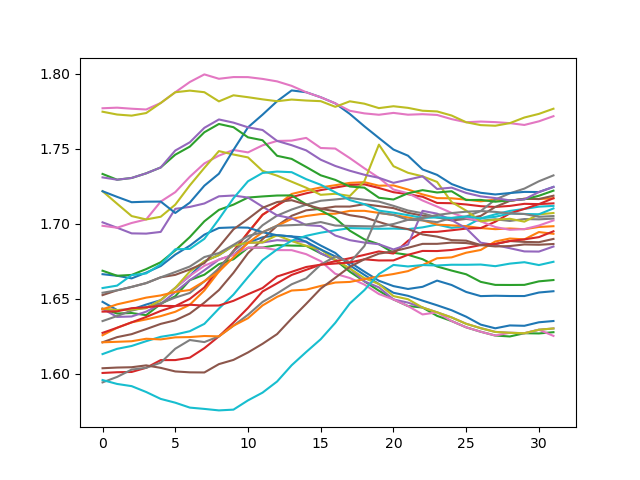

In [370]:
z = x_train[50].reshape((num_consec, 78))
z = z[:, 3:17*2-1]#:-8]
plt.figure()
plt.plot(z)
plt.show()

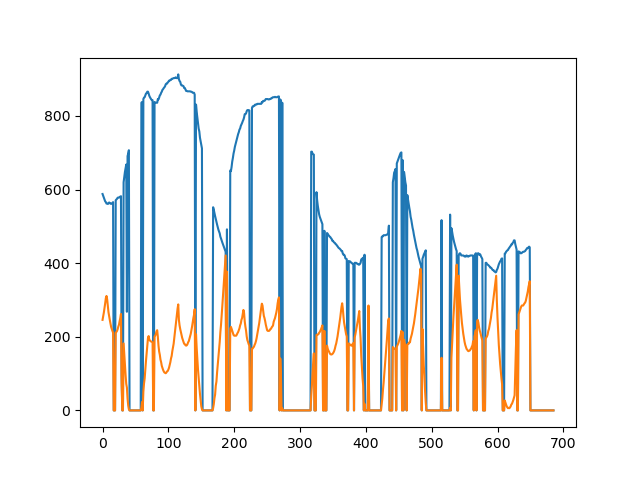

In [372]:
plt.figure()
plt.plot(x_bird)
plt.show()

# Convnet arch

In [ ]:
import tensorflow as tf
import cv2
import math

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *

drop = 0.3
input_layer = Input(shape=(x_train.shape[1],))
x = Reshape(
    target_shape=(num_consec, x_train.shape[1] // (num_consec))
)(input_layer)
x = Dense(
    32,
    kernel_regularizer=tf.keras.regularizers.l2(1e-5),
    activation='relu'
)(x)

conv_layers = []
for i in range(2, 5):
    z = Conv1D(
        32,
        i, 
        kernel_initializer='he_uniform',
        activation='swish',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5),
    )(x)
    # z = PReLU()(z)
    z = Dense(
        4,
        kernel_regularizer=tf.keras.regularizers.l2(1e-5),
        activation='relu'
    )(z)
    z = Flatten()(z)
    # z = tf.keras.backend.max(z, axis=-1)
    conv_layers.append(z)

x = Concatenate()(conv_layers)
x = Dense(
    24,
    activation='relu',
)(x)
x = Dense(
    3
)(x)
output_layer = Softmax()(x)

model = Model(input_layer, output_layer)

# N-in-N-out architecture

In [ ]:
import tensorflow as tf
import cv2
import math

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *

drop = 0.1
def conv_block(x, filters, size=3):
    x = Conv1D(
        filters, size,
        kernel_initializer='he_uniform', padding='same', 
        data_format='channels_last',
        kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
    x = Dropout(drop)(x)
    x = Activation('relu')(x)
    return x

def down_block(x, filters, repeats):
    for i in range(repeats):
        x = conv_block(x, filters, 3)
    y = AveragePooling1D(
        2, strides=2, 
        data_format='channels_last')(x)
    return y, x
    
def up_block(x, xu, filters, repeats, use_res=False, channel_first=True):
    x = concatenate([
            Conv1DTranspose(
                filters, 
                kernel_size=2, strides=2, 
                data_format='channels_last')(x), 
            xu], axis=-1)
    for i in range(repeats):
        x = conv_block(x, filters)
    return x

input_layer = Input(shape=(x_train.shape[1],))
x = Reshape(
    target_shape=(num_consec, x_train.shape[1] // (num_consec))
)(input_layer)


# # Down block
x, x1 = down_block(x, 24, 2)
x, x2 = down_block(x, 24, 2)
x, x3 = down_block(x, 24, 2)
# x, x4 = down_block(x, 80, 2)

# Bottom block
# y = [Dense(32, activation='relu')(x), Dense(32, activation='relu')(x)]
# for i in range(10):
#     x = conv_block(concatenate(y[-2:], axis=-1), 32)
#     y.append(x)

# # Up block
# x = up_block(x, x2, 16, 2)
# x = up_block(x, x1, 16, 2)

# Final output
# x = Dropout(drop)(x)
x = Flatten()(x)
x = Dense(3)(x)
output_layer = Softmax()(x)

model = Model(input_layer, output_layer)

# GRUs for shuttle detection

In [2]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# tf.config.optimizer.set_jit(False)

In [ ]:
import tensorflow as tf
import cv2
import math

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.activations import *

In [ ]:
drop = 0.1
print(x_train.shape)
input_layer = Input(shape=(x_train.shape[1],))
# x = Masking(
#     mask_value=0.,
# )(input_layer)
# x = GaussianNoise(0.01)(input_layer)

x = input_layer

x = Reshape(
    target_shape=(num_consec, x_train.shape[1] // (num_consec))
)(x)
# x = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu')(x)
# x = MaxPooling1D(pool_size=2)(x)
# x = Dense(
#     32,
#     activation='relu'
# )(x)

# x_layer = [x]
for layer in range(2):
    x = Bidirectional(GRU(
        64,
        return_sequences=True,
        # kernel_regularizer=tf.keras.regularizers.l2(1e-3),
        # dropout=drop,
    ))(x)
    # if layer > 0 and layer % 3 == 0:
    #     x = concatenate([x, x_layer[layer - 2]], axis=-1)
    # x_layer.append(x)
x = GlobalMaxPool1D()(x)
x = Dense(
    3
)(x)

output_layer = Softmax()(x)

model = Model(input_layer, output_layer)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=2.0),#tf.keras.optimizers.SGD(lr=1e-2, momentum=0.99, nesterov=True, clipnorm=2.0),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()